In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Concatenate, Dropout
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import scipy.signal
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from sklearn.metrics import mean_absolute_percentage_error



import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./sp500_2012_2022_1.csv', index_col=['symbol'])
timeline = pd.read_csv('./timeline_modified.csv')


In [3]:
print(df.isnull().sum()) # NaN values
print(np.isinf(df).sum()) # Inf values

2012-09-04 00:00:00    95
2012-09-05 00:00:00    95
2012-09-06 00:00:00    95
2012-09-07 00:00:00    95
2012-09-10 00:00:00    95
                       ..
2022-08-29 00:00:00    95
2022-08-30 00:00:00    95
2022-08-31 00:00:00    95
2022-09-01 00:00:00    95
2022-09-02 00:00:00    95
Length: 2517, dtype: int64
2012-09-04 00:00:00    0
2012-09-05 00:00:00    0
2012-09-06 00:00:00    0
2012-09-07 00:00:00    0
2012-09-10 00:00:00    0
                      ..
2022-08-29 00:00:00    0
2022-08-30 00:00:00    0
2022-08-31 00:00:00    0
2022-09-01 00:00:00    0
2022-09-02 00:00:00    0
Length: 2517, dtype: int64


In [4]:
 # replace the Inf values with NaN 
df = df.replace([np.inf, -np.inf], np.nan)
# remove the Nan values
df = df.dropna() 
df

,2012-09-04 00:00:00,2012-09-05 00:00:00,2012-09-06 00:00:00,2012-09-07 00:00:00,2012-09-10 00:00:00,2012-09-11 00:00:00,2012-09-12 00:00:00,2012-09-13 00:00:00,2012-09-14 00:00:00,2012-09-17 00:00:00,...,2022-08-22 00:00:00,2022-08-23 00:00:00,2022-08-24 00:00:00,2022-08-25 00:00:00,2022-08-26 00:00:00,2022-08-29 00:00:00,2022-08-30 00:00:00,2022-08-31 00:00:00,2022-09-01 00:00:00,2022-09-02 00:00:00
symbol,,,,,,,,,,,,,,,,,,,,,
A,24.226910,24.024202,24.508085,25.122740,25.018126,24.736950,24.514624,25.096590,25.979357,25.913960,...,133.940002,132.639999,133.669998,136.009995,129.869995,128.110001,128.279999,128.250000,128.929993,128.009995
AA,19.112680,19.339674,19.884455,20.656223,20.542728,21.178308,21.223705,21.859280,22.335964,21.745787,...,50.270000,53.090000,54.430000,56.919998,55.840000,55.500000,50.790001,49.480000,48.080002,49.250000
AAL,9.851648,10.577559,10.766107,11.444880,11.312899,10.954658,11.143203,10.605839,9.927067,9.955350,...,13.710000,13.820000,13.990000,14.420000,13.740000,13.510000,13.330000,12.990000,12.930000,12.990000
AAP,66.577797,66.558868,67.582245,66.701004,66.198776,66.852608,66.890511,65.829208,64.436256,64.332008,...,198.479996,199.050003,179.910004,180.990005,173.589996,170.539993,170.470001,168.639999,172.149994,171.729996
AAPL,20.670908,20.525747,20.710718,20.838425,20.296360,20.230518,20.512268,20.916216,21.170399,21.430712,...,167.570007,167.229996,167.529999,170.029999,163.619995,161.380005,158.910004,157.220001,157.960007,155.809998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,37.363781,37.577362,38.016361,39.007126,39.232559,39.659710,39.624111,39.873280,39.487667,39.475796,...,114.180145,114.150291,114.110489,116.250000,112.160004,112.209999,110.779999,111.239998,114.260002,112.739998
ZBH,56.282501,55.925144,57.220531,58.265789,58.042431,58.524864,58.489117,59.525452,59.766644,59.793442,...,111.360001,109.300003,109.699997,111.940002,107.510002,107.620003,107.370003,106.320000,106.800003,105.570000
ZBRA,37.270000,37.680000,38.439999,38.410000,38.240002,38.169998,38.480000,38.389999,38.410000,38.200001,...,315.880005,316.989990,319.339996,330.140015,308.160004,307.899994,302.859985,301.640015,309.739990,297.600006


In [5]:
# remove unrealistic dates
timeline['Added'] = pd.to_datetime(timeline['Added'], errors='coerce')
timeline['Removed'] = pd.to_datetime(timeline['Removed'], errors='coerce')

# date range 
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2022-01-10')  


# trial time range (minimaze the data)
timeline= timeline[
    (timeline['Added'] <= start_date) &  (timeline['Removed'] >= end_date)]

# Check cleaned data
timeline

,Ticker,Added,Removed
0,A,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
4,AAPL,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
6,ABC,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
8,ABT,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
10,ACN,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
...,...,...,...
731,XRAY,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
733,XYL,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
735,YUM,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807
736,ZBH,1677-09-21 00:12:43.145224193,2262-04-11 23:47:16.854775807


In [6]:
# filter the data according to the 'Ticker' names in timeline
filter_data = df.T
data_col = np.array(filter_data.columns)
ticker_name = timeline['Ticker'].values
filtered_ticker = np.intersect1d(data_col,ticker_name)

In [7]:
# show filtered data
data = df.loc[filtered_ticker].T
data

symbol,A,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZION
2012-09-04 00:00:00,24.226910,20.670908,33.090515,25.923016,50.499283,31.440001,31.161982,20.493223,40.629822,31.410000,...,80.586815,17.201687,76.692680,20.260799,57.143738,33.939583,20.967497,37.363781,56.282501,16.357765
2012-09-05 00:00:00,24.024202,20.525747,32.578529,26.037861,50.739124,32.259998,31.114492,20.302626,40.692745,31.299999,...,80.390190,17.208563,75.847488,20.224720,57.281467,33.808842,21.028652,37.577362,55.925144,16.383148
2012-09-06 00:00:00,24.508085,20.710718,32.971043,26.501188,52.823273,32.790001,31.937870,20.859175,41.510941,32.770000,...,80.455734,17.510706,77.324661,20.448399,58.370312,34.425228,21.814936,38.016361,57.220531,16.696264
2012-09-07 00:00:00,25.122740,20.838425,32.578529,26.410112,53.294693,32.459999,32.024956,20.805813,41.434010,32.220001,...,80.543114,17.476370,78.230789,20.275232,58.980316,34.873524,21.928503,39.007126,58.265789,17.178619
2012-09-10 00:00:00,25.018126,20.296360,32.450531,26.608116,52.947334,32.130001,31.724110,20.767691,41.287155,31.969999,...,80.717888,17.490099,78.497337,20.282444,58.691696,34.733433,21.474216,39.232559,58.042431,16.933210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-29 00:00:00,128.110001,161.380005,147.490005,101.839996,295.140015,375.260010,155.190002,90.760002,248.880005,205.710007,...,206.389999,34.646469,62.410000,75.620003,100.120003,33.080002,91.747704,112.209999,107.620003,55.750000
2022-08-30 00:00:00,128.279999,158.910004,145.429993,102.199997,292.500000,375.070007,152.729996,87.570000,245.589996,202.809998,...,206.300003,33.810898,60.209999,74.690002,96.309998,32.939999,91.049995,110.779999,107.370003,55.400002
2022-08-31 00:00:00,128.250000,157.220001,146.559998,102.650002,288.459991,373.440002,151.529999,87.889999,244.410004,201.740005,...,206.830002,33.980000,60.590000,74.250000,95.589996,32.770000,91.099998,111.239998,106.320000,55.029999
2022-09-01 00:00:00,128.929993,157.960007,147.610001,104.839996,288.790009,370.529999,150.690002,87.580002,245.960007,201.949997,...,207.089996,34.040001,59.180000,75.419998,93.870003,32.169998,92.089996,114.260002,106.800003,55.110001


In [8]:
data = data.loc[:, data.nunique() > 1]
data

symbol,A,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZION
2012-09-04 00:00:00,24.226910,20.670908,33.090515,25.923016,50.499283,31.440001,31.161982,20.493223,40.629822,31.410000,...,80.586815,17.201687,76.692680,20.260799,57.143738,33.939583,20.967497,37.363781,56.282501,16.357765
2012-09-05 00:00:00,24.024202,20.525747,32.578529,26.037861,50.739124,32.259998,31.114492,20.302626,40.692745,31.299999,...,80.390190,17.208563,75.847488,20.224720,57.281467,33.808842,21.028652,37.577362,55.925144,16.383148
2012-09-06 00:00:00,24.508085,20.710718,32.971043,26.501188,52.823273,32.790001,31.937870,20.859175,41.510941,32.770000,...,80.455734,17.510706,77.324661,20.448399,58.370312,34.425228,21.814936,38.016361,57.220531,16.696264
2012-09-07 00:00:00,25.122740,20.838425,32.578529,26.410112,53.294693,32.459999,32.024956,20.805813,41.434010,32.220001,...,80.543114,17.476370,78.230789,20.275232,58.980316,34.873524,21.928503,39.007126,58.265789,17.178619
2012-09-10 00:00:00,25.018126,20.296360,32.450531,26.608116,52.947334,32.130001,31.724110,20.767691,41.287155,31.969999,...,80.717888,17.490099,78.497337,20.282444,58.691696,34.733433,21.474216,39.232559,58.042431,16.933210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-29 00:00:00,128.110001,161.380005,147.490005,101.839996,295.140015,375.260010,155.190002,90.760002,248.880005,205.710007,...,206.389999,34.646469,62.410000,75.620003,100.120003,33.080002,91.747704,112.209999,107.620003,55.750000
2022-08-30 00:00:00,128.279999,158.910004,145.429993,102.199997,292.500000,375.070007,152.729996,87.570000,245.589996,202.809998,...,206.300003,33.810898,60.209999,74.690002,96.309998,32.939999,91.049995,110.779999,107.370003,55.400002
2022-08-31 00:00:00,128.250000,157.220001,146.559998,102.650002,288.459991,373.440002,151.529999,87.889999,244.410004,201.740005,...,206.830002,33.980000,60.590000,74.250000,95.589996,32.770000,91.099998,111.239998,106.320000,55.029999
2022-09-01 00:00:00,128.929993,157.960007,147.610001,104.839996,288.790009,370.529999,150.690002,87.580002,245.960007,201.949997,...,207.089996,34.040001,59.180000,75.419998,93.870003,32.169998,92.089996,114.260002,106.800003,55.110001


In [9]:
pair1 = 'PCAR'
pair2 = 'WTW'
price1 = data[pair1]
price2 = data[pair2]

In [10]:
pair_data = data[[pair1, pair2]]
pair_data

symbol,PCAR,WTW
2012-09-04 00:00:00,27.567303,80.586815
2012-09-05 00:00:00,27.616592,80.390190
2012-09-06 00:00:00,28.877010,80.455734
2012-09-07 00:00:00,29.369926,80.543114
2012-09-10 00:00:00,29.243170,80.717888
...,...,...
2022-08-29 00:00:00,88.879997,206.389999
2022-08-30 00:00:00,88.050003,206.300003
2022-08-31 00:00:00,87.510002,206.830002
2022-09-01 00:00:00,87.470001,207.089996


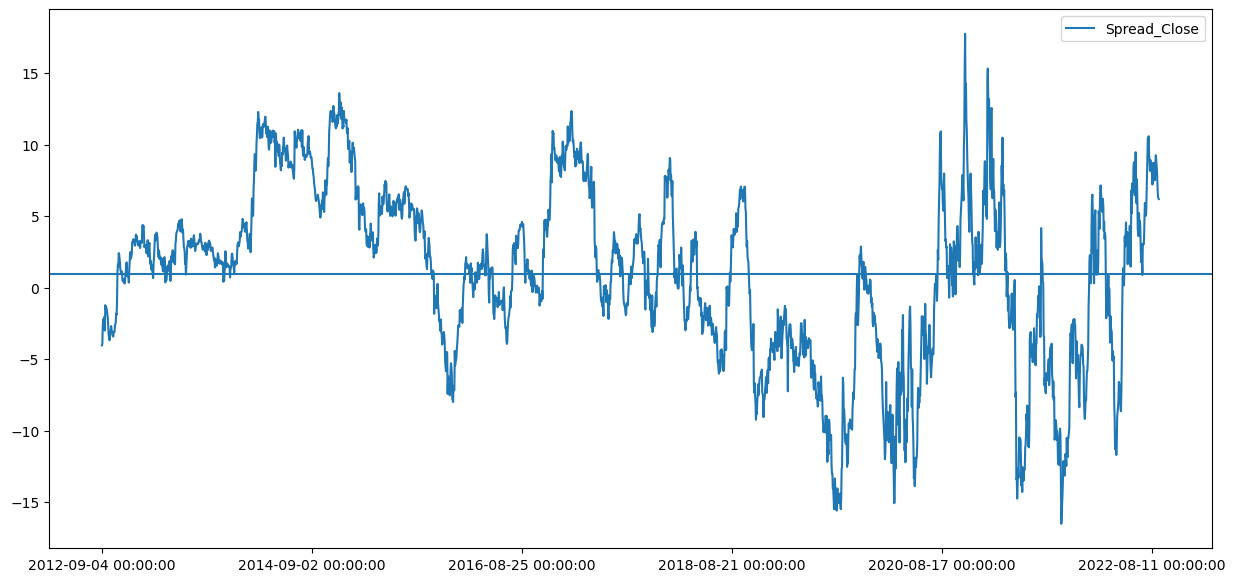

In [11]:
est = sm.OLS(pair_data[pair1], pair_data[pair2])
est = est.fit()
alpha = -est.params[0]
pair_data['Spread_Close'] = pair_data[pair1] + (pair_data[pair2] * alpha)
pair_data['Spread_Close'].plot(figsize=(15,7))
plt.axhline(pair_data['Spread_Close'].mean())
plt.legend(['Spread_Close'])

In [12]:
cols = ['Spread_Close']

lstm_pair_data = pd.DataFrame({'Spread_Close':pair_data['Spread_Close'][30:]}, columns = cols)

In [13]:
train_size = int(len(lstm_pair_data) * 0.8)
dev_size = int((len(lstm_pair_data) - train_size) * 0.5) - 10
test_size = len(lstm_pair_data) - train_size - dev_size
train, dev, test = lstm_pair_data[0:train_size], lstm_pair_data[train_size:train_size + dev_size], lstm_pair_data[train_size + dev_size:len(lstm_pair_data)]
print(len(train), len(dev), len(test))

1989 239 259


In [14]:
# PREDICTION PREIOD SETTING
look_back = 1

scaler = MinMaxScaler(feature_range=(0, 1))
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

1988
238
258


In [15]:
# ACCURACY METRIC
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)

In [16]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

yhat_ARIMA = []
yhat_ARIMA_mse = []
data5 = lstm_pair_data['Spread_Close'].values

for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    model = ARIMA(data5[:i], order=(1,0,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=look_back)
    yhat_ARIMA.append(forecast[0])
    yhat_ARIMA_mse.append(forecast)

# Calculate Mean Squared Error (MSE)
mse = acc_metric(testY, yhat_ARIMA_mse)
print(mse)

6.759653777914776


In [25]:
mean_absolute_percentage_error(testY, yhat_ARIMA_mse)

177595741554165.1

In [17]:
test_data = pd.DataFrame({'S1':pair_data[pair1].iloc[-len(testX):],'S2':pair_data[pair2].iloc[-len(testX):]})
test_data['Arima_Spread'] = yhat_ARIMA
arima_spread_data = test_data['Arima_Spread'] 

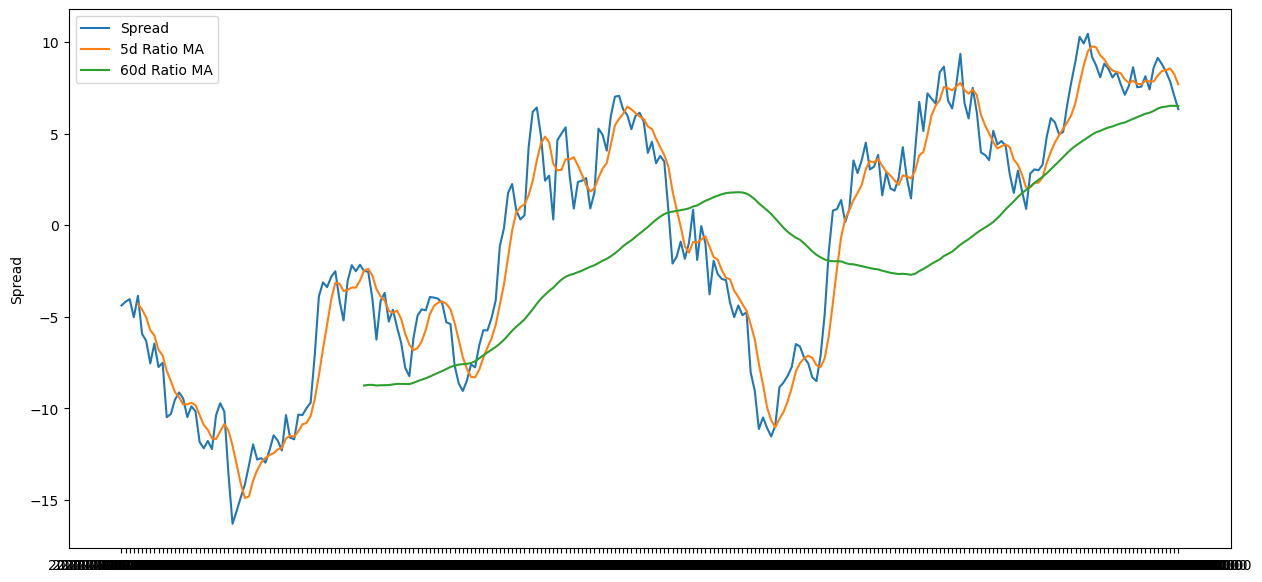

In [18]:
ratios_mavg5 = arima_spread_data.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = arima_spread_data.rolling(window=60,
                               center=False).mean()

std_60 = arima_spread_data.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(arima_spread_data.index, arima_spread_data.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Spread','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Spread')
plt.show()

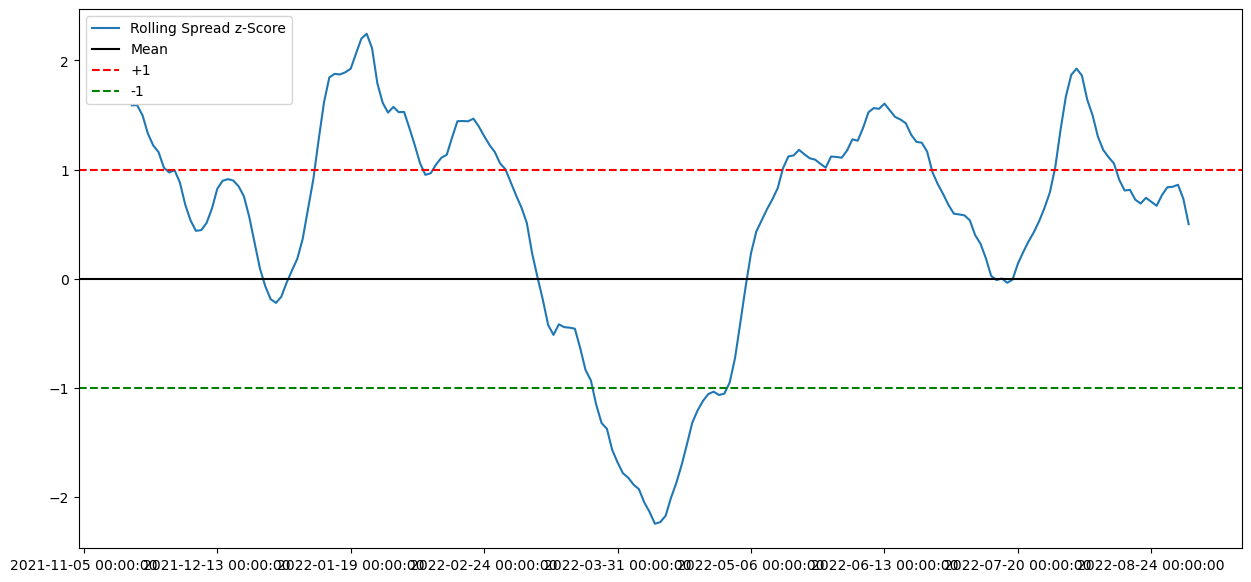

In [19]:
# Take a rolling 60 day standard deviation
std_60 = arima_spread_data.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Spread z-Score', 'Mean', '+1', '-1'])
plt.show()

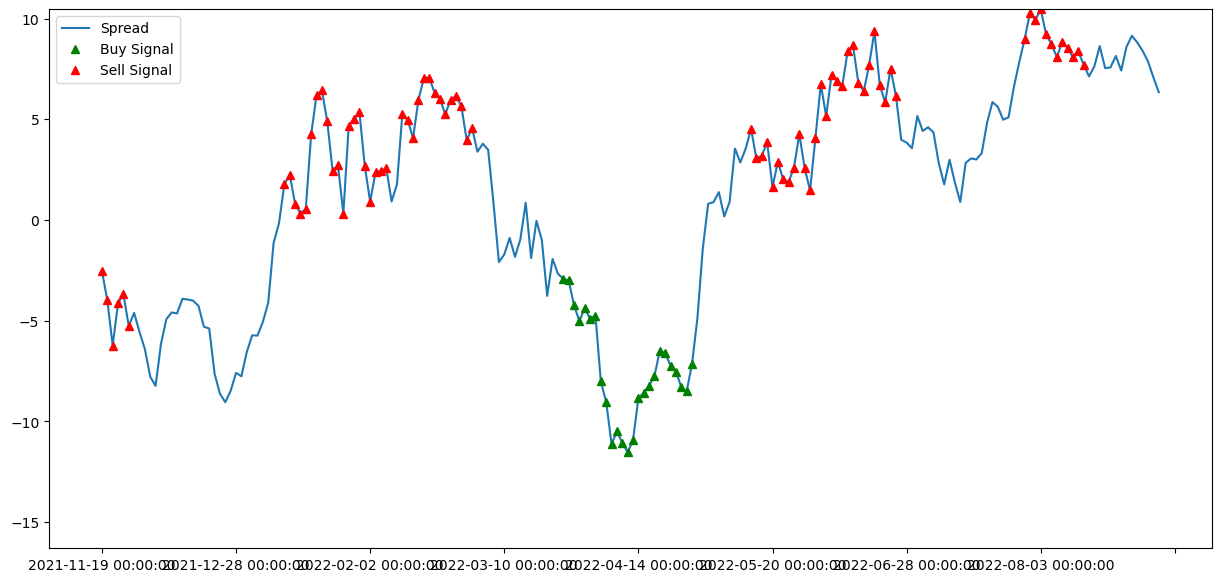

In [20]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

arima_spread_data[60:].plot()
buy = arima_spread_data.copy()
sell = arima_spread_data.copy()
buy[zscore_60_5>-1] = -100
sell[zscore_60_5<1] = -100
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,arima_spread_data.min(),arima_spread_data.max()))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.show()

In [21]:
def trade(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    money_tracker = []
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * spread[i]
            countS1 -= 1
            countS2 += spread[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * spread[i]
            countS1 += 1
            countS2 -= spread[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] - S2[i] * countS2
            countS1 = 0
            countS2 = 0
        money_tracker.append(money)
        
    return money, money_tracker

235113.13324966613


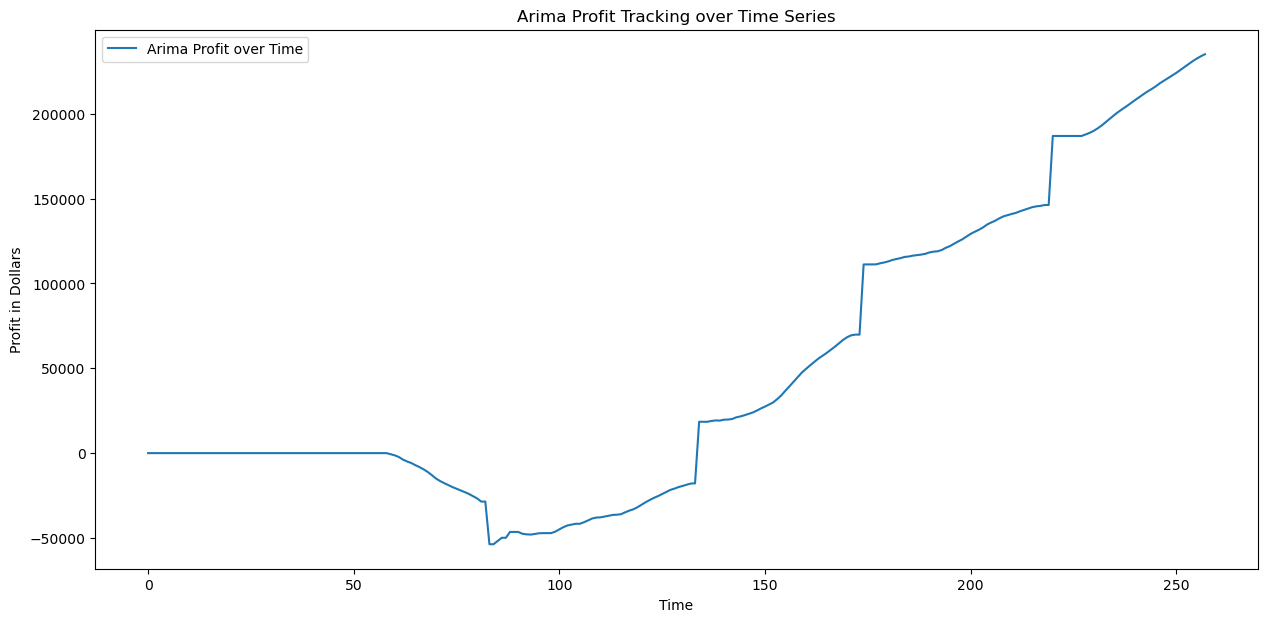

In [22]:
arima_spread_data = test_data['Arima_Spread'].reset_index(drop=True)
arima_profit , money_tracker_lstm = trade(test_data['S1'].reset_index(drop=True),
               test_data['S2'].reset_index(drop=True),
               arima_spread_data, 60, 5)
print(arima_profit)
plt.figure(figsize=(15, 7))
plt.plot(money_tracker_lstm, label='Arima Profit over Time')
plt.xlabel('Time')
plt.ylabel('Profit in Dollars')
plt.title('Arima Profit Tracking over Time Series')
plt.legend()
plt.show()